In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# 1) Creation of the distance matrix and labels

In [2]:
X = []
nb_per_group = 100

# Middle group
line_group_1 = [0] * nb_per_group + 3 * nb_per_group * [1]

for i in range(nb_per_group):
    X.append(line_group_1)

line_group_2 = [1] * nb_per_group + [0] * nb_per_group + 2 * nb_per_group * [2]
for i in range(nb_per_group):
    X.append(line_group_2)

line_group_3 = (
    [1] * nb_per_group + [2] * nb_per_group + [0] * nb_per_group + nb_per_group * [2]
)
for i in range(nb_per_group):
    X.append(line_group_3)

line_group_4 = [1] * nb_per_group + [2] * nb_per_group * 2 + [0] * nb_per_group
for i in range(nb_per_group):
    X.append(line_group_4)

X = np.array(X, float)
print(X.shape)
# Test if symetric

var = 0.2
rng = np.random.default_rng(seed=42)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        if i < j:
            if X[i, j] != X[j, i]:
                raise ValueError("Not symetric")
            rand = rng.normal(loc=0, scale=var)
            temp = X[i, j] + rand
            if temp < 0:
                temp = 0
            X[i, j] = temp
            X[j, i] = temp


# CREATION OF THE REAL LABELS
prediction = (
    [0] * nb_per_group + [1] * nb_per_group + [2] * nb_per_group + [3] * nb_per_group
)
np.unique(prediction)

(400, 400)


array([0, 1, 2, 3])

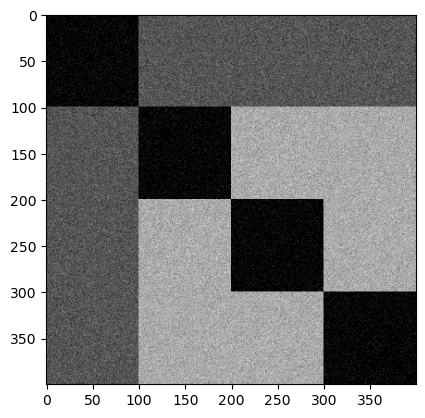

In [3]:
plt.imshow(X, cmap="gray")

# 2) Cluster the points

In [4]:
from sklearn.cluster import DBSCAN
model_DB = DBSCAN(eps=0.1, min_samples=3, metric="precomputed")
prediction_DB = model_DB.fit_predict(X)
pd.value_counts(prediction_DB)

0    100
1    100
2    100
3    100
dtype: int64

# 3) Creation of ClusterGraph

In [5]:
import clustergraph.clustergraph as cg
from clustergraph.utils import get_clusters_from_scikit

cluster_g = cg.ClusterGraph(X=X, metric_points="precomputed", clusters=get_clusters_from_scikit(prediction_DB) )

### Get colors

In [6]:
from matplotlib.colors import to_hex
from matplotlib import colormaps as cm

nb_label = 7
palette = cm.get_cmap("tab10")
color_list = [to_hex(palette(i / nb_label)) for i in range(nb_label + 1)]
color_list

dict_color = {}
for i in range(4):
    dict_color[i] = color_list[i]

color_nodes = color_list[:4]

color_points = []
for i in range(len(prediction)):
    color_points.append(dict_color[prediction[i]])

# 3) Visualization ClusterGraph

edge (0, 3, {'label': 1.002432853986412})
edge (1, 3, {'label': 1.9962485678611341})
edge (2, 3, {'label': 2.000334068349769})


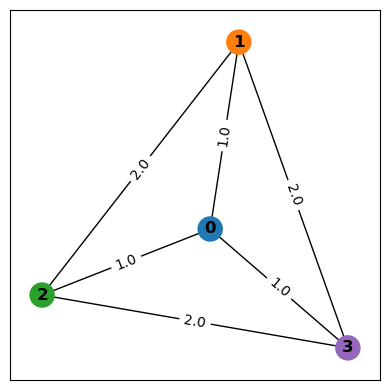

In [7]:
fig, ax = plt.subplots(figsize=(4, 4))
graph = cluster_g.graph
pos = {0: (0, 0), 1: (0.16, 0.99), 2: (-0.94, -0.35), 3: (0.77, -0.63)}

for edge in graph.edges(data=True):
    if edge[0] == 3 or edge[1] == 3:
        print("edge", edge)
    edge[2]["label"] = round(edge[2]["label"], 2)


labels = nx.get_edge_attributes(graph, "label")
nx.draw_networkx(
    graph, pos, with_labels=True, font_weight="bold", node_color=color_nodes, ax=ax
)
nx.draw_networkx_edge_labels(graph, pos, label_pos=0.5, edge_labels=labels, ax=ax)
plt.tight_layout()
#plt.savefig(fname="impossible_CG.pdf", format="pdf")
plt.show()

# 4) Dimension reduction algorithms

C:\Users\mathi\anaconda3\lib\site-packages\umap\umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


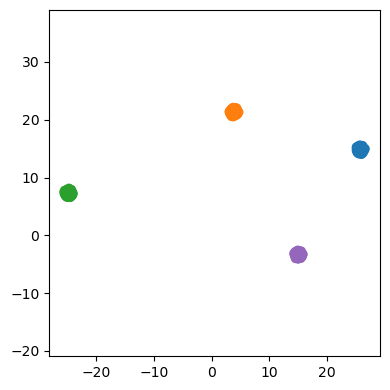

In [8]:
import umap as um
uma = um.UMAP(n_neighbors=200, metric="precomputed", random_state=42)
fig, ax = plt.subplots(figsize=(4, 4))

X_umap = uma.fit_transform(X)
ax.scatter(X_umap[:, 0], X_umap[:, 1], c=color_points)
ax.axis("equal")
plt.tight_layout()
#plt.savefig(fname="impossible_UMAP.pdf", format="pdf")

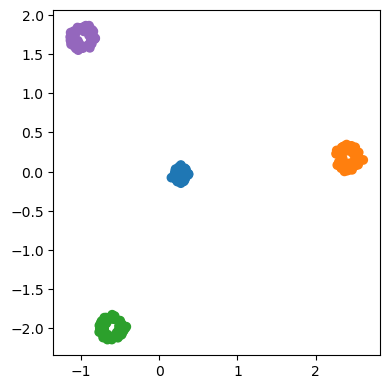

In [9]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, metric="precomputed", init="random", perplexity=200)
X_tnse = tsne.fit_transform(X)

fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(X_tnse[:, 0], X_tnse[:, 1], c=color_points)
ax.axis("equal")
plt.tight_layout()
#plt.savefig(fname="impossible_TSNE.pdf", format="pdf")
plt.show()

C:\Users\mathi\anaconda3\lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


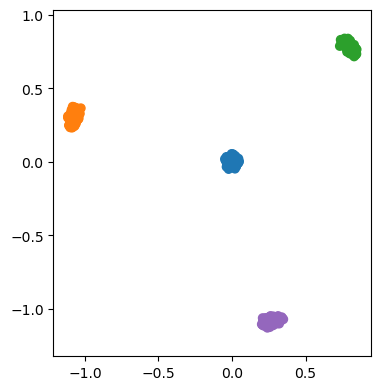

In [10]:
from sklearn.manifold import MDS

fig, ax = plt.subplots(figsize=(4, 4))
Mds = MDS(2, dissimilarity="precomputed")
X_mds = Mds.fit_transform(X)
ax.scatter(X_mds[:, 0], X_mds[:, 1], c=color_points)
ax.axis("equal")
plt.tight_layout()

Calculating PHATE...
  Running PHATE on 400 observations and 400 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.06 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.03 seconds.
    Calculating affinities...
    Calculated affinities in 0.15 seconds.
  Calculated graph and diffusion operator in 0.24 seconds.
  Calculating optimal t...
    Automatically selected t = 5
  Calculated optimal t in 0.03 seconds.
  Calculating diffusion potential...
  Calculating metric MDS...
  Calculated metric MDS in 0.09 seconds.
Calculated PHATE in 0.38 seconds.


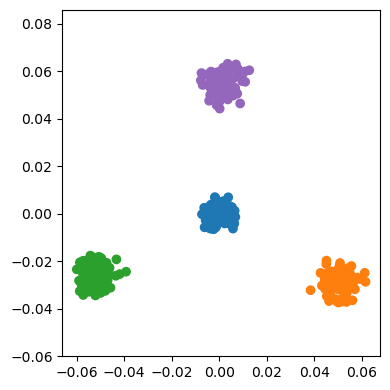

In [11]:
import phate
phate_operator = phate.PHATE(n_jobs=-2, knn=200)
X_phate = phate_operator.fit_transform(X)

fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(X_phate[:, 0], X_phate[:, 1], c=color_points)
ax.axis("equal")
plt.tight_layout()
#plt.savefig(fname="impossible_PHATE.pdf", format="pdf")
plt.show()

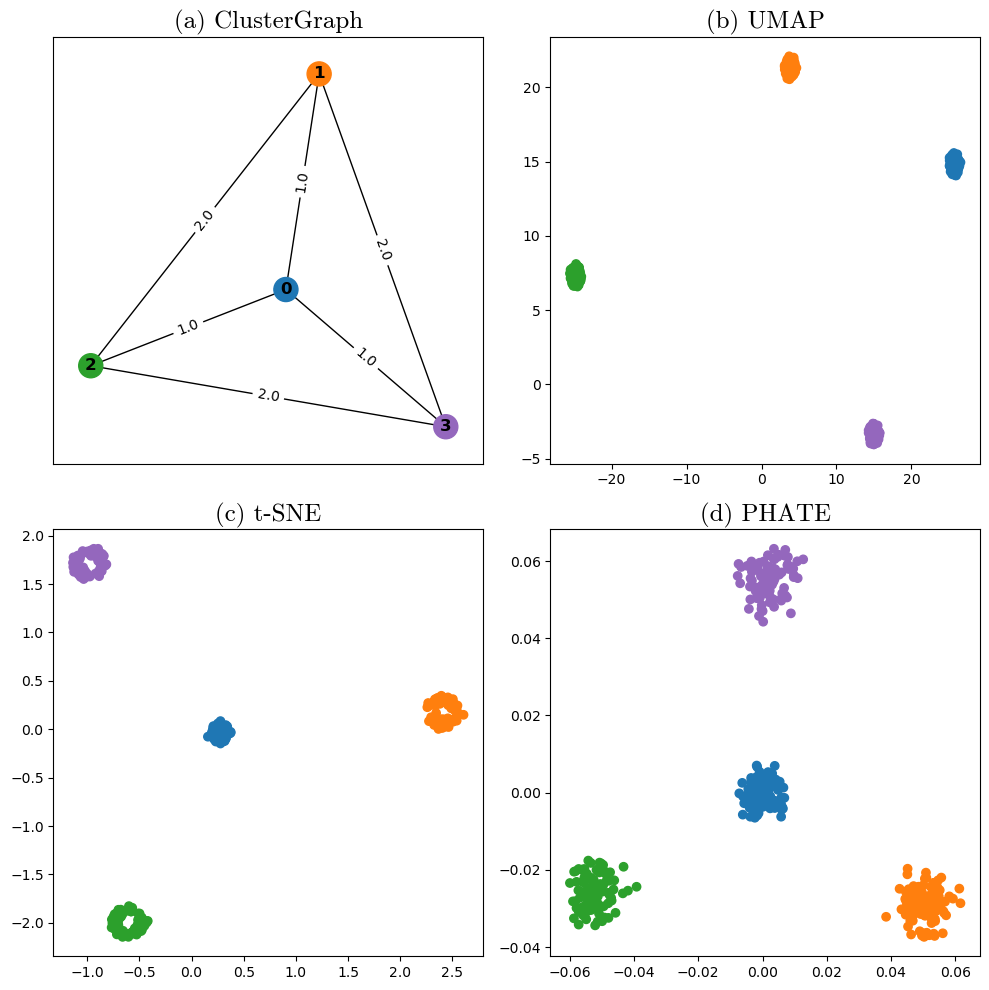

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

nx.draw_networkx(
    graph,
    pos,
    with_labels=True,
    font_weight="bold",
    node_color=color_nodes,
    ax=axs[0, 0],
)
nx.draw_networkx_edge_labels(
    graph, pos, label_pos=0.5, edge_labels=labels, ax=axs[0, 0]
)

axs[0, 0].set_title("(a) ClusterGraph", fontname="serif", family="cmr10", size=18)

axs[0, 1].scatter(X_umap[:, 0], X_umap[:, 1], c=color_points)
axs[0, 1].set_title("(b) UMAP", fontname="serif", family="cmr10", size=18)

axs[1, 0].scatter(X_tnse[:, 0], X_tnse[:, 1], c=color_points)
axs[1, 0].set_title("(c) t-SNE", fontname="serif", family="cmr10", size=18)

axs[1, 1].scatter(X_phate[:, 0], X_phate[:, 1], c=color_points)
axs[1, 1].set_title("(d) PHATE", fontname="serif", family="cmr10", size=18)

plt.tight_layout()
#plt.savefig("impossible.pdf")

In [13]:
from sklearn.metrics import pairwise_distances

def avg_distance_clusters(X):
    centers = [
        [np.average(X[i : i + 100, 0]), np.average(X[i : i + 100, 1])]
        for i in (0, 100, 200, 300)
    ]
    return pairwise_distances(centers)

In [14]:
avg_distance_clusters(X_umap) / avg_distance_clusters(X_umap)[0, 1]

array([[0.       , 1.       , 2.2347171, 0.9242589],
       [1.       , 0.       , 1.3953586, 1.1871866],
       [2.2347171, 1.3953586, 0.       , 1.8017777],
       [0.9242589, 1.1871866, 1.8017777, 0.       ]], dtype=float32)

In [15]:
avg_distance_clusters(X_tnse) / avg_distance_clusters(X_tnse)[0, 1]

array([[0.        , 1.        , 0.99951744, 0.9986482 ],
       [1.        , 0.        , 1.7314347 , 1.7297428 ],
       [0.99951744, 1.7314347 , 0.        , 1.7317948 ],
       [0.9986482 , 1.7297428 , 1.7317948 , 0.        ]], dtype=float32)

In [16]:
avg_distance_clusters(X_phate) / avg_distance_clusters(X_phate)[0, 1]

array([[0.        , 1.        , 1.00326066, 0.95492209],
       [1.        , 0.        , 1.77294348, 1.67204252],
       [1.00326066, 1.77294348, 0.        , 1.67799619],
       [0.95492209, 1.67204252, 1.67799619, 0.        ]])

In [17]:
avg_distance_clusters(X_mds) / avg_distance_clusters(X_mds)[0, 1]

array([[0.        , 1.        , 0.99935972, 1.00043192],
       [1.        , 0.        , 1.73186762, 1.73037165],
       [0.99935972, 1.73186762, 0.        , 1.73354546],
       [1.00043192, 1.73037165, 1.73354546, 0.        ]])